# Formatting Models According to Your Use Case
To preprocess data for Spark’s different advanced analytics tools, you must consider your end
objective. The following list walks through the requirements for input data structure for each
advanced analytics task in MLlib:
1. In the case of most classification and regression algorithms, you want to get your data
into a column of type Double to represent the label and a column of type Vector (either
dense or sparse) to represent the features.
2. In the case of recommendation, you want to get your data into a column of users, a
column of items (say movies or books), and a column of ratings.
3. In the case of unsupervised learning, a column of type Vector (either dense or sparse) is
needed to represent the features.
4. In the case of graph analytics, you will want a DataFrame of vertices and a DataFrame
of edges.

The best way to get your data in these formats is through transformers. Transformers are
functions that accept a DataFrame as an argument and return a new DataFrame as a response.
This chapter will focus on what transformers are relevant for particular use cases rather than
attempting to enumerate every possible transformer.

## NOTE
Spark provides a number of transformers as part of the org.apache.spark.ml.feature package. The
corresponding package in Python is pyspark.ml.feature. New transformers are constantly popping
up in Spark MLlib and therefore it is impossible to include a definitive list in this book. The most upto-
date information can be found on the Spark documentation site.

Before we proceed, we’re going to read in several different sample datasets, each of which has
different properties we will manipulate in this chapter:

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
sc.setSystemProperty('spark.executor.memory', '5g')
sc.setSystemProperty('spark.driver.memory', '3g')

spark = SparkSession(sc)

In [2]:
sales = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("../data/retail-data/by-day/*.csv")\
.coalesce(5)\
.where("Description IS NOT NULL")
#fakeIntDF = spark.read.parquet("../data/simple-ml-integers")
simpleDF = spark.read.json("../data/simple-ml")
#scaleDF = spark.read.parquet("../data/simple-ml-scaling")

In [3]:
scaleDF = spark.read.parquet("../data/simple-ml-scaling")

In [4]:
fakeIntDF = spark.read.parquet("../data/simple-ml-integers")

In addition to this realistic sales data, we’re going to use several simple synthetic datasets as
well. FakeIntDF, simpleDF, and scaleDF all have very few rows. This will give you the ability
to focus on the exact data manipulation we are performing instead of the various inconsistencies
of any particular dataset. Because we’re going to be accessing the sales data a number of times,
we’re going to cache it so we can read it efficiently from memory as opposed to reading it from
disk every time we need it. Let’s also check out the first several rows of data in order to better
understand what’s in the dataset:

In [5]:
sales.cache()
sales.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
|   580538|    21544|SKULLS  WATER TRA...|      48|2011-12-05 08:38:00|     0.85|   14075.0|United Kingdom|
|   580538|    23126|FELTCRA

## Transformers
We discussed transformers in the previous chapter, but it’s worth reviewing them again here.
Transformers are functions that convert raw data in some way. This might be to create a new
interaction variable (from two other variables), to normalize a column, or to simply turn it into a
Double to be input into a model. Transformers are primarily used in preprocessing or feature
generation.

Spark’s transformer only includes a transform method. This is because it will not change based
on the input data.

The Tokenizer is an example of a transformer. It tokenizes a string, splitting on a given
character, and has nothing to learn from our data; it simply applies a function. We’ll discuss the
tokenizer in more depth later in this chapter, but here’s a small code snippet showing how a
tokenizer is built to accept the input column, how it transforms the data, and then the output from
that transformation:

In [6]:
#// in Scala
#import org.apache.spark.ml.feature.Tokenizer
#val tkn = new Tokenizer().setInputCol("Description")
#tkn.transform(sales.select("Description")).show(false)

## Estimators for Preprocessing
Another tool for preprocessing are estimators. An estimator is necessary when a transformation
you would like to perform must be initialized with data or information about the input column
(often derived by doing a pass over the input column itself). For example, if you wanted to scale
the values in our column to have mean zero and unit variance, you would need to perform a pass
over the entire data in order to calculate the values you would use to normalize the data to mean
zero and unit variance. In effect, an estimator can be a transformer configured according to your
particular input data. In simplest terms, you can either blindly apply a transformation (a “regular”
transformer type) or perform a transformation based on your data (an estimator type). Figure 25-
2 is a simple illustration of an estimator fitting to a particular input dataset, generating a
transformer that is then applied to the input dataset to append a new column (of the transformed
data).
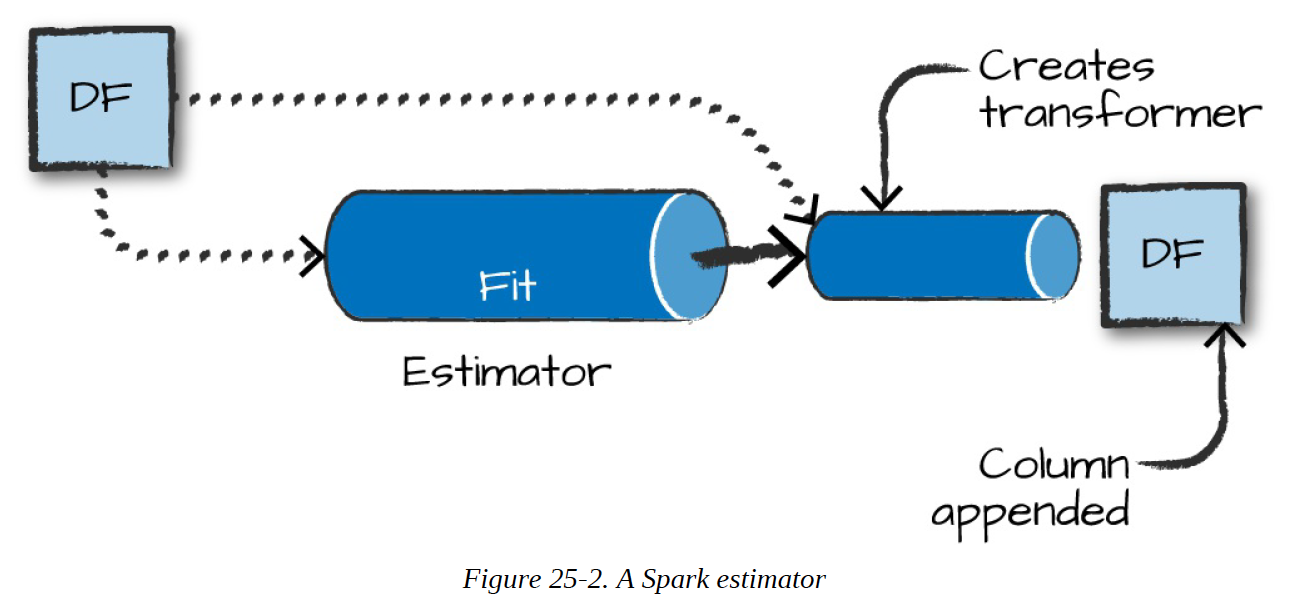

An example of this type of estimator is the StandardScaler, which scales your input column
according to the range of values in that column to have a zero mean and a variance of 1 in each
dimension. For that reason it must first perform a pass over the data to create the transformer.
Here’s a sample code snippet showing the entire process, as well as the output:

In [7]:
#// in Scala
#import org.apache.spark.ml.feature.StandardScaler
#val ss = new StandardScaler().setInputCol("features")
#ss.fit(scaleDF).transform(scaleDF).show(false)

## Transformer Properties
All transformers require you to specify, at a minimum, the inputCol and the outputCol, which
represent the column name of the input and output, respectively. You set these with
setInputCol and setOutputCol. There are some defaults (you can find these in the
documentation), but it is a best practice to manually specify them yourself for clarity. In addition
to input and output columns, all transformers have different parameters that you can tune
(whenever we mention a parameter in this chapter you must set it with a set() method). In
Python, we also have another method to set these values with keyword arguments to the object’s
constructor. We exclude these from the examples in the next chapter for consistency. Estimators
require you to fit the transformer to your particular dataset and then call transform on the
resulting object.

## NOTE
Spark MLlib stores metadata about the columns it uses in each DataFrame as an attribute on the
column itself. This allows it to properly store (and annotate) that a column of Doubles may actually
represent a series of categorical variables instead of continuous values. However, metadata won’t show
up when you print the schema or the DataFrame.

# High-Level Transformers
High-level transformers, such as the RFormula we saw in the previous chapter, allow you to
concisely specify a number of transformations in one. These operate at a “high level”, and allow
you to avoid doing data manipulations or transformations one by one. In general, you should try
to use the highest level transformers you can, in order to minimize the risk of error and help you
focus on the business problem instead of the smaller details of implementation. While this is not
always possible, it’s a good objective.

## RFormula
The RFormula is the easiest transfomer to use when you have “conventionally” formatted data.
Spark borrows this transformer from the R language to make it simple to declaratively specify a
set of transformations for your data. With this transformer, values can be either numerical or
categorical and you do not need to extract values from strings or manipulate them in any way.
The RFormula will automatically handle categorical inputs (specified as strings) by performing
something called one-hot encoding. In brief, one-hot encoding converts a set of values into a set
of binary columns specifying whether or not the data point has each particular value (we’ll
discuss one-hot encoding in more depth later in the chapter). With the RFormula, numeric
columns will be cast to Double but will not be one-hot encoded. If the label column is of type
String, it will be first transformed to Double with StringIndexer.

### WARNING
Automatic casting of numeric columns to Double without one-hot encoding has some important
implications. If you have numerically valued categorical variables, they will only be cast to Double,
implicitly specifying an order. It is important to ensure the input types correspond to the expected
conversion. If you have categorical variables that really have no order relation, they should be cast to
String. You can also manually index columns (see “Working with Categorical Features”).

The RFormula allows you to specify your transformations in declarative syntax. It is simple to
use once you understand the syntax. Currently, RFormula supports a limited subset of the R
operators that in practice work quite well for simple transformations. The basic operators are:
1. ~
Separate target and terms
2. +
Concatenate terms; “+ 0” means removing the intercept (this means the y-intercept of the line
that we will fit will be 0)
3. -
Remove a term; “- 1” means removing intercept (this means the y-intercept of the line that
we will fit will be 0)
4. :
Interaction (multiplication for numeric values, or binarized categorical values)
5. .
All columns except the target/dependent variable

RFormula also uses default columns of label and features to label, you guessed it, the label
and the set of features that it outputs (for supervised machine learning). The models covered later
on in this chapter by default require those column names, making it easy to pass the resulting
transformed DataFrame into a model for training. If this doesn’t make sense yet, don’t worry—
it’ll become clear once we actually start using models in later chapters.

Let’s use RFormula in an example. In this case, we want to use all available variables (the .) and
then specify an interaction between value1 and color and value2 and color as additional
features to generate:

In [8]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="lab ~ . + color:value1 + color:value2")
supervised.fit(simpleDF).transform(simpleDF).show()

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red|good|    45| 38.97187133755819|(10,[0,2,3,4,7],[...|  1.0|
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| ba

## SQL Transformers
A SQLTransformer allows you to leverage Spark’s vast library of SQL-related manipulations
just as you would a MLlib transformation. Any SELECT statement you can use in SQL is a valid
transformation. The only thing you need to change is that instead of using the table name, you
should just use the keyword TH IS. You might want to use SQLTransformer if you want to
formally codify some DataFrame manipulation as a preprocessing step, or try different SQL
expressions for features during hyperparameter tuning. Also note that the output of this
transformation will be appended as a column to the output DataFrame.

You might want to use an SQLTransformer in order to represent all of your manipulations on the
very rawest form of your data so you can version different variations of manipulations as
transformers. This gives you the benefit of building and testing varying pipelines, all by simply
swapping out transformers. The following is a basic example of using SQLTransformer:

In [9]:
from pyspark.ml.feature import SQLTransformer
basicTransformation = SQLTransformer()\
.setStatement("""
SELECT sum(Quantity), count(*), CustomerID
FROM __THIS__
GROUP BY CustomerID
""")
basicTransformation.transform(sales).show()

+-------------+--------+----------+
|sum(Quantity)|count(1)|CustomerID|
+-------------+--------+----------+
|          119|      62|   14452.0|
|          440|     143|   16916.0|
|          630|      72|   17633.0|
|           34|       6|   14768.0|
|         1542|      30|   13094.0|
|          854|     117|   17884.0|
|           97|      12|   16596.0|
|          290|      98|   13607.0|
|          541|      27|   14285.0|
|          244|      31|   16561.0|
|          491|     152|   13956.0|
|          204|      76|   13533.0|
|          493|      64|   16629.0|
|          159|      38|   17267.0|
|         1140|      30|   13918.0|
|           55|      28|   18114.0|
|           88|       7|   14473.0|
|          150|      16|   14024.0|
|          206|      23|   12493.0|
|          138|      18|   15776.0|
+-------------+--------+----------+
only showing top 20 rows



## VectorAssembler
The VectorAssembler is a tool you’ll use in nearly every single pipeline you generate. It helps
concatenate all your features into one big vector you can then pass into an estimator. It’s used
typically in the last step of a machine learning pipeline and takes as input a number of columns
of Boolean, Double, or Vector. This is particularly helpful if you’re going to perform a number
of manipulations using a variety of transformers and need to gather all of those results together.
The output from the following code snippet will make it clear how this works:

In [10]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler().setInputCols(["int1", "int2", "int3"])
va.transform(fakeIntDF).show()

+----+----+----+------------------------------------+
|int1|int2|int3|VectorAssembler_6bae49278a4e__output|
+----+----+----+------------------------------------+
|   1|   2|   3|                       [1.0,2.0,3.0]|
|   7|   8|   9|                       [7.0,8.0,9.0]|
|   4|   5|   6|                       [4.0,5.0,6.0]|
+----+----+----+------------------------------------+



# Working with Continuous Features
Continuous features are just values on the number line, from positive infinity to negative infinity.
There are two common transformers for continuous features. First, you can convert continuous
features into categorical features via a process called bucketing, or you can scale and normalize
your features according to several different requirements. These transformers will only work on
Double types, so make sure you’ve turned any other numerical values to Double:

In [11]:
contDF = spark.range(20).selectExpr("cast(id as double)")

## Bucketing
The most straightforward approach to bucketing or binning is using the Bucketizer. This will
split a given continuous feature into the buckets of your designation. You specify how buckets
should be created via an array or list of Double values. This is useful because you may want to
simplify the features in your dataset or simplify their representations for interpretation later on.
For example, imagine you have a column that represents a person’s weight and you would like to
predict some value based on this information. In some cases, it might be simpler to create three
buckets of “overweight,” “average,” and “underweight.”

To specify the bucket, set its borders. For example, setting splits to 5.0, 10.0, 250.0 on our
contDF will actually fail because we don’t cover all possible input ranges. When specifying your
bucket points, the values you pass into splits must satisfy three requirements:
1. The minimum value in your splits array must be less than the minimum value in your
DataFrame.
2. The maximum value in your splits array must be greater than the maximum value in
your DataFrame.
3. You need to specify at a minimum three values in the splits array, which creates two
buckets.

To cover all possible ranges, scala.Double.NegativeInfinity might be another split option,
with scala.Double.PositiveInfinity to cover all possible ranges outside of the inner splits.
In Python we specify this in the following way: float("inf"), float("-inf").

In order to handle null or NaN values, we must specify the handleInvalid parameter as a
certain value. We can either keep those values (keep), error or null, or skip those rows.
Here’s an example of using bucketing:

In [12]:
from pyspark.ml.feature import Bucketizer
bucketBorders = [-1.0, 5.0, 10.0, 250.0, 600.0]
bucketer = Bucketizer().setSplits(bucketBorders).setInputCol("id")
bucketer.transform(contDF).show()

+----+-------------------------------+
|  id|Bucketizer_54204d279542__output|
+----+-------------------------------+
| 0.0|                            0.0|
| 1.0|                            0.0|
| 2.0|                            0.0|
| 3.0|                            0.0|
| 4.0|                            0.0|
| 5.0|                            1.0|
| 6.0|                            1.0|
| 7.0|                            1.0|
| 8.0|                            1.0|
| 9.0|                            1.0|
|10.0|                            2.0|
|11.0|                            2.0|
|12.0|                            2.0|
|13.0|                            2.0|
|14.0|                            2.0|
|15.0|                            2.0|
|16.0|                            2.0|
|17.0|                            2.0|
|18.0|                            2.0|
|19.0|                            2.0|
+----+-------------------------------+



In addition to splitting based on hardcoded values, another option is to split based on percentiles
in our data. This is done with QuantileDiscretizer, which will bucket the values into userspecified
buckets with the splits being determined by approximate quantiles values. For instance,
the 90th quantile is the point in your data at which 90% of the data is below that value. You can
control how finely the buckets should be split by setting the relative error for the approximate
quantiles calculation using setRelativeError. Spark does this is by allowing you to specify the
number of buckets you would like out of the data and it will split up your data accordingly. The
following is an example:

In [13]:
from pyspark.ml.feature import QuantileDiscretizer
bucketer = QuantileDiscretizer().setNumBuckets(5).setInputCol("id")
fittedBucketer = bucketer.fit(contDF)
fittedBucketer.transform(contDF).show()

+----+----------------------------------------+
|  id|QuantileDiscretizer_0955c987ed61__output|
+----+----------------------------------------+
| 0.0|                                     0.0|
| 1.0|                                     0.0|
| 2.0|                                     0.0|
| 3.0|                                     1.0|
| 4.0|                                     1.0|
| 5.0|                                     1.0|
| 6.0|                                     1.0|
| 7.0|                                     2.0|
| 8.0|                                     2.0|
| 9.0|                                     2.0|
|10.0|                                     2.0|
|11.0|                                     3.0|
|12.0|                                     3.0|
|13.0|                                     3.0|
|14.0|                                     3.0|
|15.0|                                     4.0|
|16.0|                                     4.0|
|17.0|                                  

## Advanced bucketing techniques
The techniques descriubed here are the most common ways of bucketing data, but there are a
number of other ways that exist in Spark today. All of these processes are the same from a data
flow perspective: start with continuous data and place them in buckets so that they become
categorical. Differences arise depending on the algorithm used to compute these buckets. The
simple examples we just looked at are easy to intepret and work with, but more advanced
techniques such as locality sensitivity hashing (LSH) are also available in MLlib.

# Scaling and Normalization
We saw how we can use bucketing to create groups out of continuous variables. Another
common task is to scale and normalize continuous data. While not always necessary, doing so is
usually a best practice. You might want to do this when your data contains a number of columns
based on different scales.

## StandardScaler
The StandardScaler standardizes a set of features to have zero mean and a standard deviation
of 1. The flag withStd will scale the data to unit standard deviation while the flag withMean
(false by default) will center the data prior to scaling it.
### WARNING
Centering can be very expensive on sparse vectors because it generally turns them into dense vectors,
so be careful before centering your data.

In [14]:
from pyspark.ml.feature import StandardScaler
sScaler = StandardScaler().setInputCol("features")
sScaler.fit(scaleDF).transform(scaleDF).show()

+---+--------------+-----------------------------------+
| id|      features|StandardScaler_fb93b8ee2825__output|
+---+--------------+-----------------------------------+
|  0|[1.0,0.1,-1.0]|               [1.19522860933439...|
|  1| [2.0,1.1,1.0]|               [2.39045721866878...|
|  0|[1.0,0.1,-1.0]|               [1.19522860933439...|
|  1| [2.0,1.1,1.0]|               [2.39045721866878...|
|  1|[3.0,10.1,3.0]|               [3.58568582800318...|
+---+--------------+-----------------------------------+



## MinMaxScaler
The MinMaxScaler will scale the values in a vector (component wise) to the proportional values
on a scale from a given min value to a max value. If you specify the minimum value to be 0 and
the maximum value to be 1, then all the values will fall in between 0 and 1:

In [15]:
from pyspark.ml.feature import MinMaxScaler
minMax = MinMaxScaler().setMin(5).setMax(10).setInputCol("features")
fittedminMax = minMax.fit(scaleDF)
fittedminMax.transform(scaleDF).show()

+---+--------------+---------------------------------+
| id|      features|MinMaxScaler_b893d8ac3bef__output|
+---+--------------+---------------------------------+
|  0|[1.0,0.1,-1.0]|                    [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                    [7.5,5.5,7.5]|
|  0|[1.0,0.1,-1.0]|                    [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                    [7.5,5.5,7.5]|
|  1|[3.0,10.1,3.0]|                 [10.0,10.0,10.0]|
+---+--------------+---------------------------------+



## MaxAbsScaler
The max absolute scaler (MaxAbsScaler) scales the data by dividing each value by the maximum
absolute value in this feature. All values therefore end up between −1 and 1. This transformer
does not shift or center the data at all in the process:

In [16]:
from pyspark.ml.feature import MaxAbsScaler
maScaler = MaxAbsScaler().setInputCol("features")
fittedmaScaler = maScaler.fit(scaleDF)
fittedmaScaler.transform(scaleDF).show()

+---+--------------+---------------------------------+
| id|      features|MaxAbsScaler_8505d1d5fdab__output|
+---+--------------+---------------------------------+
|  0|[1.0,0.1,-1.0]|             [0.33333333333333...|
|  1| [2.0,1.1,1.0]|             [0.66666666666666...|
|  0|[1.0,0.1,-1.0]|             [0.33333333333333...|
|  1| [2.0,1.1,1.0]|             [0.66666666666666...|
|  1|[3.0,10.1,3.0]|                    [1.0,1.0,1.0]|
+---+--------------+---------------------------------+



## ElementwiseProduct
The ElementwiseProduct allows us to scale each value in a vector by an arbitrary value. For
example, given the vector below and the row “1, 0.1, -1” the output will be “10, 1.5, -20.”
Naturally the dimensions of the scaling vector must match the dimensions of the vector inside
the relevant column:

In [17]:
from pyspark.ml.feature import ElementwiseProduct
from pyspark.ml.linalg import Vectors
scaleUpVec = Vectors.dense(10.0, 15.0, 20.0)
scalingUp = ElementwiseProduct()\
.setScalingVec(scaleUpVec)\
.setInputCol("features")
scalingUp.transform(scaleDF).show()

+---+--------------+---------------------------------------+
| id|      features|ElementwiseProduct_cecc9720407d__output|
+---+--------------+---------------------------------------+
|  0|[1.0,0.1,-1.0]|                       [10.0,1.5,-20.0]|
|  1| [2.0,1.1,1.0]|                       [20.0,16.5,20.0]|
|  0|[1.0,0.1,-1.0]|                       [10.0,1.5,-20.0]|
|  1| [2.0,1.1,1.0]|                       [20.0,16.5,20.0]|
|  1|[3.0,10.1,3.0]|                      [30.0,151.5,60.0]|
+---+--------------+---------------------------------------+



## Normalizer
The normalizer allows us to scale multidimensional vectors using one of several power norms,
set through the parameter “p”. For example, we can use the Manhattan norm (or Manhattan
distance) with p = 1, Euclidean norm with p = 2, and so on. The Manhattan distance is a measure
of distance where you can only travel from point to point along the straight lines of an axis (like
the streets in Manhattan).
Here’s an example of using the Normalizer:

In [18]:
from pyspark.ml.feature import Normalizer
manhattanDistance = Normalizer().setP(1).setInputCol("features")
manhattanDistance.transform(scaleDF).show()

+---+--------------+-------------------------------+
| id|      features|Normalizer_e6de09c9482d__output|
+---+--------------+-------------------------------+
|  0|[1.0,0.1,-1.0]|           [0.47619047619047...|
|  1| [2.0,1.1,1.0]|           [0.48780487804878...|
|  0|[1.0,0.1,-1.0]|           [0.47619047619047...|
|  1| [2.0,1.1,1.0]|           [0.48780487804878...|
|  1|[3.0,10.1,3.0]|           [0.18633540372670...|
+---+--------------+-------------------------------+



# Working with Categorical Features
The most common task for categorical features is indexing. Indexing converts a categorical
variable in a column to a numerical one that you can plug into machine learning algorithms.
While this is conceptually simple, there are some catches that are important to keep in mind so
that Spark can do this in a stable and repeatable manner.

In general, we recommend re-indexing every categorical variable when pre-processing just for
consistency’s sake. This can be helpful in maintaining your models over the long run as your
encoding practices may change over time.

## StringIndexer
The simplest way to index is via the StringIndexer, which maps strings to different numerical
IDs. Spark’s StringIndexer also creates metadata attached to the DataFrame that specify what
inputs correspond to what outputs. This allows us later to get inputs back from their respective
index values:

In [19]:
from pyspark.ml.feature import StringIndexer
lblIndxr = StringIndexer().setInputCol("lab").setOutputCol("labelInd")
idxRes = lblIndxr.fit(simpleDF).transform(simpleDF)
idxRes.show()

+-----+----+------+------------------+--------+
|color| lab|value1|            value2|labelInd|
+-----+----+------+------------------+--------+
|green|good|     1|14.386294994851129|     1.0|
| blue| bad|     8|14.386294994851129|     0.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     1.0|
|green|good|    12|14.386294994851129|     1.0|
|green| bad|    16|14.386294994851129|     0.0|
|  red|good|    35|14.386294994851129|     1.0|
|  red| bad|     1| 38.97187133755819|     0.0|
|  red| bad|     2|14.386294994851129|     0.0|
|  red| bad|    16|14.386294994851129|     0.0|
|  red|good|    45| 38.97187133755819|     1.0|
|green|good|     1|14.386294994851129|     1.0|
| blue| bad|     8|14.386294994851129|     0.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     1.0|
|green|good|    12|14.386294994851129|     1.0|
|green| bad|    16|14.386294994851129|     0.0|
|  red|good|    35|14.386294994851129|  

Keep in mind that the StringIndexer is an estimator that must be fit on the input data. This
means it must see all inputs to select a mapping of inputs to IDs. If you train a StringIndexer
on inputs “a,” “b,” and “c” and then go to use it against input “d,” it will throw an error by
default. Another option is to skip the entire row if the input value was not a value seen during
training. Going along with the previous example, an input value of “d” would cause that row to
be skipped entirely. We can set this option before or after training the indexer or pipeline. More
options may be added to this feature in the future but as of Spark 2.2, you can only skip or throw
an error on invalid inputs.

In [20]:
# valIndexer.setHandleInvalid("skip")
# valIndexer.fit(simpleDF).setHandleInvalid("skip")

## Converting Indexed Values Back to Text
When inspecting your machine learning results, you’re likely going to want to map back to the
original values. Since MLlib classification models make predictions using the indexed values,
this conversion is useful for converting model predictions (indices) back to the original
categories. We can do this with IndexToString. You’ll notice that we do not have to input our
value to the String key; Spark’s MLlib maintains this metadata for you. You can optionally
specify the outputs.

In [21]:
from pyspark.ml.feature import IndexToString
labelReverse = IndexToString().setInputCol("labelInd")
labelReverse.transform(idxRes).show()

+-----+----+------+------------------+--------+----------------------------------+
|color| lab|value1|            value2|labelInd|IndexToString_c1e439e978f6__output|
+-----+----+------+------------------+--------+----------------------------------+
|green|good|     1|14.386294994851129|     1.0|                              good|
| blue| bad|     8|14.386294994851129|     0.0|                               bad|
| blue| bad|    12|14.386294994851129|     0.0|                               bad|
|green|good|    15| 38.97187133755819|     1.0|                              good|
|green|good|    12|14.386294994851129|     1.0|                              good|
|green| bad|    16|14.386294994851129|     0.0|                               bad|
|  red|good|    35|14.386294994851129|     1.0|                              good|
|  red| bad|     1| 38.97187133755819|     0.0|                               bad|
|  red| bad|     2|14.386294994851129|     0.0|                               bad|
|  r

## Indexing in Vectors
VectorIndexer is a helpful tool for working with categorical variables that are already found
inside of vectors in your dataset. This tool will automatically find categorical features inside of
your input vectors and convert them to categorical features with zero-based category indices. For
example, in the following DataFrame, the first column in our Vector is a categorical variable
with two different categories while the rest of the variables are continuous. By setting
maxCategories to 2 in our VectorIndexer, we are instructing Spark to take any column in our
vector with two or less distinct values and convert it to a categorical variable. This can be helpful
when you know how many unique values there are in your largest category because you can
specify this and it will automatically index the values accordingly. Conversely, Spark changes
the data based on this parameter, so if you have continuous variables that don’t appear
particularly continuous (lots of repeated values) these can be unintentionally converted to
categorical variables if there are too few unique values.

In [22]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.linalg import Vectors
idxIn = spark.createDataFrame([
(Vectors.dense(1, 2, 3),1),
(Vectors.dense(2, 5, 6),2),
(Vectors.dense(1, 8, 9),3)
]).toDF("features", "label")
indxr = VectorIndexer()\
.setInputCol("features")\
.setOutputCol("idxed")\
.setMaxCategories(2)
indxr.fit(idxIn).transform(idxIn).show()

+-------------+-----+-------------+
|     features|label|        idxed|
+-------------+-----+-------------+
|[1.0,2.0,3.0]|    1|[0.0,2.0,3.0]|
|[2.0,5.0,6.0]|    2|[1.0,5.0,6.0]|
|[1.0,8.0,9.0]|    3|[0.0,8.0,9.0]|
+-------------+-----+-------------+



## One-Hot Encoding
Indexing categorical variables is only half of the story. One-hot encoding is an extremely
common data transformation performed after indexing categorical variables. This is because
indexing does not always represent our categorical variables in the correct way for downstream
models to process. For instance, when we index our “color” column, you will notice that some
colors have a higher value (or index number) than others (in our case, blue is 1 and green is 2).

This is incorrect because it gives the mathematical appearance that the input to the machine
learning algorithm seems to specify that green > blue, which makes no sense in the case of the
current categories. To avoid this, we use OneHotEncoder, which will convert each distinct value
to a Boolean flag (1 or 0) as a component in a vector. When we encode the color value, then we
can see these are no longer ordered, making them easier for downstream models (e.g., a linear
model) to process:

In [23]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
lblIndxr = StringIndexer().setInputCol("color").setOutputCol("colorInd")
colorLab = lblIndxr.fit(simpleDF).transform(simpleDF.select("color"))
ohe = OneHotEncoder().setInputCol("colorInd")
ohe = ohe.fit(colorLab)
ohe.transform(colorLab).show()

+-----+--------+----------------------------------+
|color|colorInd|OneHotEncoder_1578c006c426__output|
+-----+--------+----------------------------------+
|green|     1.0|                     (2,[1],[1.0])|
| blue|     2.0|                         (2,[],[])|
| blue|     2.0|                         (2,[],[])|
|green|     1.0|                     (2,[1],[1.0])|
|green|     1.0|                     (2,[1],[1.0])|
|green|     1.0|                     (2,[1],[1.0])|
|  red|     0.0|                     (2,[0],[1.0])|
|  red|     0.0|                     (2,[0],[1.0])|
|  red|     0.0|                     (2,[0],[1.0])|
|  red|     0.0|                     (2,[0],[1.0])|
|  red|     0.0|                     (2,[0],[1.0])|
|green|     1.0|                     (2,[1],[1.0])|
| blue|     2.0|                         (2,[],[])|
| blue|     2.0|                         (2,[],[])|
|green|     1.0|                     (2,[1],[1.0])|
|green|     1.0|                     (2,[1],[1.0])|
|green|     

# Text Data Transformers
Text is always tricky input because it often requires lots of manipulation to map to a format that
a machine learning model will be able to use effectively. There are generally two kinds of texts
you’ll see: free-form text and string categorical variables. This section primarily focuses on freeform
text because we already discussed categorical variables.

## Tokenizing Text
Tokenization is the process of converting free-form text into a list of “tokens” or individual
words. The easiest way to do this is by using the Tokenizer class. This transformer will take a
string of words, separated by whitespace, and convert them into an array of words. For example,
in our dataset we might want to convert the Description field into a list of tokens.

In [24]:
from pyspark.ml.feature import Tokenizer
tkn = Tokenizer().setInputCol("Description").setOutputCol("DescOut")
tokenized = tkn.transform(sales.select("Description"))
tokenized.show(20, False)

+-----------------------------------+------------------------------------------+
|Description                        |DescOut                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, , water, transfer, tattoos]      |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

We can also create a Tokenizer that is not just based white space but a regular expression with
the RegexTokenizer. The format of the regular expression should conform to the Java Regular
Expression (RegEx) syntax:

In [25]:
from pyspark.ml.feature import RegexTokenizer
rt = RegexTokenizer()\
.setInputCol("Description")\
.setOutputCol("DescOut")\
.setPattern(" ")\
.setToLowercase(True)
rt.transform(sales.select("Description")).show(20, False)

+-----------------------------------+------------------------------------------+
|Description                        |DescOut                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, water, transfer, tattoos]        |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

Another way of using the RegexTokenizer is to use it to output values matching the provided
pattern instead of using it as a gap. We do this by setting the gaps parameter to false. Doing this
with a space as a pattern returns all the spaces, which is not too useful, but if we made our
pattern capture individual words, we could return those:

In [26]:
from pyspark.ml.feature import RegexTokenizer
rt = RegexTokenizer()\
.setInputCol("Description")\
.setOutputCol("DescOut")\
.setPattern(" ")\
.setGaps(False)\
.setToLowercase(True)
rt.transform(sales.select("Description")).show(20, False)

+-----------------------------------+------------------+
|Description                        |DescOut           |
+-----------------------------------+------------------+
|RABBIT NIGHT LIGHT                 |[ ,  ]            |
|DOUGHNUT LIP GLOSS                 |[ ,  ,  ]         |
|12 MESSAGE CARDS WITH ENVELOPES    |[ ,  ,  ,  ]      |
|BLUE HARMONICA IN BOX              |[ ,  ,  ,  ]      |
|GUMBALL COAT RACK                  |[ ,  ]            |
|SKULLS  WATER TRANSFER TATTOOS     |[ ,  ,  ,  ,  ]   |
|FELTCRAFT GIRL AMELIE KIT          |[ ,  ,  ]         |
|CAMOUFLAGE LED TORCH               |[ ,  ]            |
|WHITE SKULL HOT WATER BOTTLE       |[ ,  ,  ,  ,  ]   |
|ENGLISH ROSE HOT WATER BOTTLE      |[ ,  ,  ,  ]      |
|HOT WATER BOTTLE KEEP CALM         |[ ,  ,  ,  ]      |
|SCOTTIE DOG HOT WATER BOTTLE       |[ ,  ,  ,  ]      |
|ROSE CARAVAN DOORSTOP              |[ ,  ]            |
|GINGHAM HEART  DOORSTOP RED        |[ ,  ,  ,  ]      |
|STORAGE TIN VINTAGE LEAF      

## Removing Common Words
A common task after tokenization is to filter stop words, common words that are not relevant in
many kinds of analysis and should thus be removed. Frequently occurring stop words in English
include “the,” “and,” and “but.” Spark contains a list of default stop words you can see by calling
the following method, which can be made case insensitive if necessary (as of Spark 2.2,
supported languages for stopwords are “danish,” “dutch,” “english,” “finnish,” “french,”
“german,” “hungarian,” “italian,” “norwegian,” “portuguese,” “russian,” “spanish,” “swedish,”
and “turkish”):

In [27]:
from pyspark.ml.feature import StopWordsRemover
englishStopWords = StopWordsRemover.loadDefaultStopWords("english")
stops = StopWordsRemover()\
.setStopWords(englishStopWords)\
.setInputCol("DescOut")
stops.transform(tokenized).show()

+--------------------+--------------------+-------------------------------------+
|         Description|             DescOut|StopWordsRemover_8cda260ef3e0__output|
+--------------------+--------------------+-------------------------------------+
|  RABBIT NIGHT LIGHT|[rabbit, night, l...|                 [rabbit, night, l...|
| DOUGHNUT LIP GLOSS |[doughnut, lip, g...|                 [doughnut, lip, g...|
|12 MESSAGE CARDS ...|[12, message, car...|                 [12, message, car...|
|BLUE HARMONICA IN...|[blue, harmonica,...|                 [blue, harmonica,...|
|   GUMBALL COAT RACK|[gumball, coat, r...|                 [gumball, coat, r...|
|SKULLS  WATER TRA...|[skulls, , water,...|                 [skulls, , water,...|
|FELTCRAFT GIRL AM...|[feltcraft, girl,...|                 [feltcraft, girl,...|
|CAMOUFLAGE LED TORCH|[camouflage, led,...|                 [camouflage, led,...|
|WHITE SKULL HOT W...|[white, skull, ho...|                 [white, skull, ho...|
|ENGLISH ROSE HO

Notice how the word of is removed in the output column. That’s because it’s such a common
word that it isn’t relevant to any downstream manipulation and simply adds noise to our dataset.
## Creating Word Combinations
Tokenizing our strings and filtering stop words leaves us with a clean set of words to use as
features. It is often of interest to look at combinations of words, usually by looking at colocated
words. Word combinations are technically referred to as n-grams—that is, sequences of words of
length n. An n-gram of length 1 is called a unigrams; those of length 2 are called bigrams, and
those of length 3 are called trigrams (anything above those are just four-gram, five-gram, etc.),
Order matters with n-gram creation, so converting a sentence with three words into bigram
representation would result in two bigrams. The goal when creating n-grams is to better capture
sentence structure and more information than can be gleaned by simply looking at all words
individually. Let’s create some n-grams to illustrate this concept.

With n-grams, we can look at sequences of words that commonly co-occur and use them as
inputs to a machine learning algorithm. These can create better features than simply looking at
all of the words individually (say, tokenized on a space character):

In [28]:
from pyspark.ml.feature import NGram
unigram = NGram().setInputCol("DescOut").setN(1)
bigram = NGram().setInputCol("DescOut").setN(2)
unigram.transform(tokenized.select("DescOut")).show(2, False)
bigram.transform(tokenized.select("DescOut")).show(2, False)

+----------------------+--------------------------+
|DescOut               |NGram_37abaeb63aca__output|
+----------------------+--------------------------+
|[rabbit, night, light]|[rabbit, night, light]    |
|[doughnut, lip, gloss]|[doughnut, lip, gloss]    |
+----------------------+--------------------------+
only showing top 2 rows

+----------------------+---------------------------+
|DescOut               |NGram_254deca9717c__output |
+----------------------+---------------------------+
|[rabbit, night, light]|[rabbit night, night light]|
|[doughnut, lip, gloss]|[doughnut lip, lip gloss]  |
+----------------------+---------------------------+
only showing top 2 rows



## Converting Words into Numerical Representations
Once you have word features, it’s time to start counting instances of words and word
combinations for use in our models. The simplest way is just to include binary counts of a word
in a given document (in our case, a row). Essentially, we’re measuring whether or not each row
contains a given word. This is a simple way to normalize for document sizes and occurrence
counts and get numerical features that allow us to classify documents based on content. In
addition, we can count words using a CountVectorizer, or reweigh them according to the
prevalence of a given word in all the documents using a TF–IDF transformation (discussed next).

In [29]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer()\
.setInputCol("DescOut")\
.setOutputCol("countVec")\
.setVocabSize(500)\
.setMinTF(1)\
.setMinDF(2)
fittedCV = cv.fit(tokenized)
fittedCV.transform(tokenized).show(10, False)

+-------------------------------+-------------------------------------+---------------------------------------------+
|Description                    |DescOut                              |countVec                                     |
+-------------------------------+-------------------------------------+---------------------------------------------+
|RABBIT NIGHT LIGHT             |[rabbit, night, light]               |(500,[150,185,212],[1.0,1.0,1.0])            |
|DOUGHNUT LIP GLOSS             |[doughnut, lip, gloss]               |(500,[462,463,492],[1.0,1.0,1.0])            |
|12 MESSAGE CARDS WITH ENVELOPES|[12, message, cards, with, envelopes]|(500,[35,41,166],[1.0,1.0,1.0])              |
|BLUE HARMONICA IN BOX          |[blue, harmonica, in, box]           |(500,[10,16,36,352],[1.0,1.0,1.0,1.0])       |
|GUMBALL COAT RACK              |[gumball, coat, rack]                |(500,[228,280,407],[1.0,1.0,1.0])            |
|SKULLS  WATER TRANSFER TATTOOS |[skulls, , water, trans

While the output looks a little complicated, it’s actually just a sparse vector that contains the total
vocabulary size, the index of the word in the vocabulary, and then the counts of that particular
word:
## Term frequency–inverse document frequency
Another way to approach the problem of converting text into a numerical representation is to use
term frequency–inverse document frequency (TF–IDF). In simplest terms, TF–IDF measures
how often a word occurs in each document, weighted according to how many documents that
word occurs in.

In [30]:
tfIdfIn = tokenized\
.where("array_contains(DescOut, 'red')")\
.select("DescOut")\
.limit(10)
tfIdfIn.show(10, False)

+---------------------------------------+
|DescOut                                |
+---------------------------------------+
|[gingham, heart, , doorstop, red]      |
|[red, floral, feltcraft, shoulder, bag]|
|[alarm, clock, bakelike, red]          |
|[pin, cushion, babushka, red]          |
|[red, retrospot, mini, cases]          |
|[red, kitchen, scales]                 |
|[gingham, heart, , doorstop, red]      |
|[large, red, babushka, notebook]       |
|[red, retrospot, oven, glove]          |
|[red, retrospot, plate]                |
+---------------------------------------+



We can see some overlapping words in these documents, but these words provide at least a rough
topic-like representation. Now let’s input that into TF–IDF. To do this, we’re going to hash each
word and convert it to a numerical representation, and then weigh each word in the voculary
according to the inverse document frequency. Hashing is a similar process as CountVectorizer,
but is irreversible—that is, from our output index for a word, we cannot get our input word
(multiple words might map to the same output index):

In [31]:
from pyspark.ml.feature import HashingTF, IDF
tf = HashingTF()\
.setInputCol("DescOut")\
.setOutputCol("TFOut")\
.setNumFeatures(10000)
idf = IDF()\
.setInputCol("TFOut")\
.setOutputCol("IDFOut")\
.setMinDocFreq(2)

In [32]:
idf.fit(tf.transform(tfIdfIn)).transform(tf.transform(tfIdfIn)).show(10, False)

+---------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|DescOut                                |TFOut                                                |IDFOut                                                                                                           |
+---------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|[gingham, heart, , doorstop, red]      |(10000,[52,804,3372,6594,9808],[1.0,1.0,1.0,1.0,1.0])|(10000,[52,804,3372,6594,9808],[0.0,1.2992829841302609,1.2992829841302609,1.2992829841302609,1.2992829841302609])|
|[red, floral, feltcraft, shoulder, bag]|(10000,[50,52,415,6756,8005],[1.0,1.0,1.0,1.0,1.0])  |(10000,[50,52,415,6756,8005],[0.0,0.0,0.0,0.0,0.0])              

(10000,[2591,4291,4456],[1.0116009116784799,0.0,0.0])

This vector is represented using three different values: the total vocabulary size, the hash of
every word appearing in the document, and the weighting of each of those terms. This is similar
to the CountVectorizer output.

## Word2Vec
Word2Vec is a deep learning–based tool for computing a vector representation of a set of words.
The goal is to have similar words close to one another in this vector space, so we can then make
generalizations about the words themselves. This model is easy to train and use, and has been
shown to be useful in a number of natural language processing applications, including entity
recognition, disambiguation, parsing, tagging, and machine translation.

In [33]:
from pyspark.ml.feature import Word2Vec
# Input data: Each row is a bag of words from a sentence or document.
documentDF = spark.createDataFrame([
("Hi I heard about Spark".split(" "), ),
("I wish Java could use case classes".split(" "), ),
("Logistic regression models are neat".split(" "), )
], ["text"])
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="text",
outputCol="result")
model = word2Vec.fit(documentDF)
result = model.transform(documentDF)
for row in result.collect():
    text, vector = row
    print("Text: [%s] => \nVector: %s\n" % (", ".join(text), str(vector)))

Text: [Hi, I, heard, about, Spark] => 
Vector: [0.02036476763896644,0.00627172663807869,0.0049649406224489216]

Text: [I, wish, Java, could, use, case, classes] => 
Vector: [0.06342963767903191,0.01215339491942099,-0.05633769024695669]

Text: [Logistic, regression, models, are, neat] => 
Vector: [-0.017420613393187522,0.008711700141429902,-0.013818052783608438]



# Feature Manipulation
While nearly every transformer in ML manipulates the feature space in some way, the following
algorithms and tools are automated means of either expanding the input feature vectors or
reducing them to a lower number of dimensions.

## PCA
Principal Components Analysis (PCA) is a mathematical technique for finding the most
important aspects of our data (the principal components). It changes the feature representation of
our data by creating a new set of features (“aspects”). Each new feature is a combination of the
original features. The power of PCA is that it can create a smaller set of more meaningful
features to be input into your model, at the potential cost of interpretability.

You’d want to use PCA if you have a large input dataset and want to reduce the total number of
features you have. This frequently comes up in text analysis where the entire feature space is
massive and many of the features are largely irrelevant. Using PCA, we can find the most
important combinations of features and only include those in our machine learning model. PCA
takes a parameter 􁽅, specifying the number of output features to create. Generally, this should be
much smaller than your input vectors’ dimension.

### NOTE
Picking the right 􁽅 is nontrivial and there’s no prescription we can give. Check out the relevant
chapters in ESL and ISL for more information.

In [34]:
from pyspark.ml.feature import PCA
pca = PCA().setInputCol("features").setK(2)
pca.fit(scaleDF).transform(scaleDF).show(20, False)

+---+--------------+------------------------------------------+
|id |features      |PCA_7e5eb8219922__output                  |
+---+--------------+------------------------------------------+
|0  |[1.0,0.1,-1.0]|[0.0713719499248417,-0.4526654888147805]  |
|1  |[2.0,1.1,1.0] |[-1.6804946984073723,1.2593401322219198]  |
|0  |[1.0,0.1,-1.0]|[0.0713719499248417,-0.4526654888147805]  |
|1  |[2.0,1.1,1.0] |[-1.6804946984073723,1.2593401322219198]  |
|1  |[3.0,10.1,3.0]|[-10.872398139848944,0.030962697060155975]|
+---+--------------+------------------------------------------+



## Interaction
In some cases, you might have domain knowledge about specific variables in your dataset. For
example, you might know that a certain interaction between the two variables is an important
variable to include in a downstream estimator. The feature transformer Interaction allows you
to create an interaction between two variables manually. It just multiplies the two features
together—something that a typical linear model would not do for every possible pair of features
in your data. This transformer is currently only available directly in Scala but can be called from
any language using the RFormula. We recommend users just use RFormula instead of manually
creating interactions.
## Polynomial Expansion
Polynomial expansion is used to generate interaction variables of all the input columns. With
polynomial expansion, we specify to what degree we would like to see various interactions. For
example, for a degree-2 polynomial, Spark takes every value in our feature vector, multiplies it
by every other value in the feature vector, and then stores the results as features. For instance, if
we have two input features, we’ll get four output features if we use a second degree polynomial
(2x2). If we have three input features, we’ll get nine output features (3x3). If we use a thirddegree
polynomial, we’ll get 27 output features (3x3x3) and so on. This transformation is useful
when you want to see interactions between particular features but aren’t necessarily sure about
which interactions to consider.

### WARNING
Polynomial expansion can greatly increase your feature space, leading to both high computational
costs and overfitting. Use it with caution, especially for higher degrees.

In [35]:
from pyspark.ml.feature import PolynomialExpansion
pe = PolynomialExpansion().setInputCol("features").setDegree(2)
pe.transform(scaleDF).show()

+---+--------------+----------------------------------------+
| id|      features|PolynomialExpansion_380dbe0ba69d__output|
+---+--------------+----------------------------------------+
|  0|[1.0,0.1,-1.0]|                    [1.0,1.0,0.1,0.1,...|
|  1| [2.0,1.1,1.0]|                    [2.0,4.0,1.1,2.2,...|
|  0|[1.0,0.1,-1.0]|                    [1.0,1.0,0.1,0.1,...|
|  1| [2.0,1.1,1.0]|                    [2.0,4.0,1.1,2.2,...|
|  1|[3.0,10.1,3.0]|                    [3.0,9.0,10.1,30....|
+---+--------------+----------------------------------------+



# Feature Selection
Often, you will have a large range of possible features and want to select a smaller subset to use
for training. For example, many features might be correlated, or using too many features might
lead to overfitting. This process is called feature selection. There are a number of ways to
evaluate feature importance once you’ve trained a model but another option is to do some rough
filtering beforehand. Spark has some simple options for doing that, such as ChiSqSelector.
## ChiSqSelector
ChiSqSelector leverages a statistical test to identify features that are not independent from the
label we are trying to predict, and drop the uncorrelated features. It’s often used with categorical
data in order to reduce the number of features you will input into your model, as well as to
reduce the dimensionality of text data (in the form of frequencies or counts). Since this method is
based on the Chi-Square test, there are several different ways we can pick the “best” features.
The methods are numTopFeatures, which is ordered by p-value; percentile, which takes a
proportion of the input features (instead of just the top N features); and fpr, which sets a cut off
p-value.

We will demonstrate this with the output of the CountVectorizer created earlier in this chapter:

In [36]:
from pyspark.ml.feature import ChiSqSelector, Tokenizer
tkn = Tokenizer().setInputCol("Description").setOutputCol("DescOut")
tokenized = tkn\
.transform(sales.select("Description", "CustomerId"))\
.where("CustomerId IS NOT NULL")
prechi = fittedCV.transform(tokenized)\
.where("CustomerId IS NOT NULL")
chisq = ChiSqSelector()\
.setFeaturesCol("countVec")\
.setLabelCol("CustomerId")\
.setNumTopFeatures(2)

chisq.fit(prechi).transform(prechi)\
.drop("customerId", "Description", "DescOut").show()

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59210)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    se

Py4JError: An error occurred while calling o971.fit

# Advanced Topics
There are several advanced topics surrounding transformers and estimators. Here we touch on
the two most common, persisting transformers as well as writing custom ones.
## Persisting Transformers
Once you’ve used an estimator to configure a transformer, it can be helpful to write it to disk and
simply load it when necessary (e.g., for use in another Spark session). We saw this in the
previous chapter when we persisted an entire pipeline. To persist a transformer individually, we
use the write method on the fitted transformer (or the standard transformer) and specify the
location:

In [ ]:
fittedPCA = pca.fit(scaleDF)
fittedPCA.write().overwrite().save("/tmp/fittedPCA")

We can then load it back in:

In [ ]:
from pyspark.ml.feature import PCAModel
loadedPCA = PCAModel.load("/tmp/fittedPCA")
loadedPCA.transform(scaleDF).show()

# Conclusion
This chapter gave a whirlwind tour of many of the most common preprocessing transformations
Spark has available. There are several domain-specific ones we did not have enough room to
cover (e.g., Discrete Cosine Transform), but you can find more information in the
documentation. This area of Spark is also constantly growing as the community develops new
ones.

Another important aspect of this feature engineering toolkit is consistency. In the previous
chapter we covered the pipeline concept, an essential tool to package and train end-to-end ML
workflows. In the next chapter we will start going through the variety of machine learning tasks you may have and what algorithms are available for each one.